# VISST data viewer

This code views data from VISST netcdf files created by Patrick Minnis. 

In [307]:
# Load required libraries
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import datetime
import math
import glob
import os
%matplotlib inline

In [308]:
# Input the range of dates and time wanted for the collection of images
year = 2006
start_day = 1
start_month = 1
start_hour = 0
start_minute = 0
start_second = 0

end_month = 1
end_day = 3
end_hour = 12
end_minute = 00
end_second = 00

start_time = datetime.datetime(year, start_month, start_day, start_hour, start_minute, start_second)
end_time = datetime.datetime(year, end_month, end_day, end_hour, end_minute, end_second)
deltatime = end_time - start_time


if(deltatime.seconds > 0 or deltatime.minute > 0):
    no_days = deltatime.days + 1
else:
    no_days = deltatime.days
    
days = np.arange(0, no_days,1)
print('We are about to load grid files for ' + str(no_days) + ' days')
data_path = '/home/rjackson/data/visst/'

# Find the list of files for each day
cur_time = start_time

file_list = []
time_list = []
for i in days:
    year_str = "%04d" % cur_time.year
    day_str = "%02d" % cur_time.day
    month_str = "%02d" % cur_time.month
    print('Looking for files with format ' + data_path + 'twpvisstgrid*' +  year_str + month_str + day_str + '*.cdf')
    data_list = glob.glob(data_path + 'twpvisstgrid*' +  year_str + month_str + day_str + '*.cdf')
    file_list.append(data_list[0])
    time_list.append(cur_time)
    cur_time = cur_time + datetime.timedelta(days=1)



We are about to load grid files for 3 days
Looking for files with format /home/rjackson/data/visst/twpvisstgrid*20060101*.cdf
Looking for files with format /home/rjackson/data/visst/twpvisstgrid*20060102*.cdf
Looking for files with format /home/rjackson/data/visst/twpvisstgrid*20060103*.cdf


# NetCDF parameters in VISST file:

latitude = latitude of pixel<br />
longtiude = longtidue of pixel<br />
time = time in seconds after midnight<br />
cloud_percentage = Cloud percentage<br />
optical_depth_linear = Linear average of optical depth<br />
optical_depth_log = Log average of optical depth<br />
optical_depth_linear_sd = Linear standard deviation of optical depth<br />
optical_depth_log_sd = Log standard deviation of optical depth<br />
ir_emit = IR emissivity average<br />
it_emit_sd = IR emissiviey standard deviation<br />
particle_size = Average particle size<br />
particle_size_sd = Particle size standard deviation<br />
water_path = Water path average<br />
water_path_sd = Water path standard deviation<br />
cloud_height_top = Cloud height top average<br />
cloud_height_top_sd = Cloud height top standard deviation<br />
cloud_height_base = Cloud base height average<br />
cloud_height_base_sd = Cloud base height sd<br />
cloud_pressure_top_sd = Cloud pressure top standard deviation<br />
cloud_pressure_center_average = Cloud pressure center average<br />
cloud_pressure_center_sd = Cloud pressure center std dev.<br />
cloud_pressure_base = Cloud base pressure<br />
ir_temperature = Infrared temperature average<br />
broadband_shortwave_albedo = Broadband shortwave albedo average<br />
broadband_longwave_flux = Broadband longwave flux<br />
surface_net_shortwave_flux = Surface net shortwave flux average<br />
surface_net_longwave_flux = Surface net longwave flux average<br />
surface_down_shortwave_flux = Shortwave downward flux average<br />
surface_down_longwave_flux = Longwave downward flux average<br />

clearsky_ir_temperature = long_name: Infrared clear sky temperature average<br />  
clearsky_vis_reflectance = Visible clear sky reflectance average<br />
cloud_temperature = Cloud temperature average<br />
cloud_temperature_sd = Cloud temperature standard deviation<br />
visible_reflectance = Visible reflectance average<br />
cloud_percentage_level = Cloud percentage at 3 levels<br />
cloud_temperature_top_level = Cloud temperature top average at 3 levels<br />
cloud_temperature_center_level = Cloud temperature center average at 3 levels<br />
cloud_temperature_base_level = Cloud temperature base average at 3 levels<br />
cloud_pressure_top_level = Cloud pressure top average at 3 levels<br />
cloud_pressure_center_level = Cloud pressure center average at 3 levels<br />
cloud_pressure_base_level = Cloud pressure base average at 3 levels<br />
optical_depth_linear_level = Optical depth linear average at 3 levels<br />
optical_depth_log_level = Optical depth log average at 3 levels<br />
cloud_height_top_level = Cloud height top average at 3 levels<br />
cloud_height_center_level = Cloud height center average at 3 levels<br />
cloud_height_base_level = Cloud height base average at 3 levels<br />
                  
The data frequency is once an hour. Since different satellites were used from 2003 to 2014 in the VISST database,<br /> different parameters at different sampling frequencies may be available. <br />

Dimensions for 3D variables are time by lat by lon by (level or cloud type)


Since time is in seconds after midnight, we need to use datetime to convert it to HH:MM:SS for the plot. These functions look for the closest timestep to the specified time.

In [309]:
# Find the index in the file that is closest to the timestamp you specify
def find_closest_timestep_index(scan_hour, scan_minute, scan_second=0):
   
   time_stamp = datetime.datetime(year, 
                                  month,
                                  day,
                                  scan_hour, 
                                  scan_minute, 
                                  scan_second)
   
   indicies = np.arange(1, len(Time))
   

   # Set the initial value for minimum difference between scan time and input time to be unrealistically large (> 1 day)
   min_delta_time = datetime.timedelta(40)
   
   for i in indicies:
       hours = math.floor(Time[i]/3600)
       minutes = math.floor((Time[i] - hours*3600)/60)
       seconds = Time[i] - hours*3600 - minutes*60;
       temp = datetime.datetime(year,
                                month,
                                day,
                                int(hours), 
                                int(minutes),
                                int(seconds))
       delta_time = abs(temp - time_stamp)
       if(delta_time < min_delta_time):
            min_delta_time = delta_time
            lowest_index = i
     
   return lowest_index   

# Convert seconds to midnight to a string format
def seconds_to_midnight_to_string(time_secs_after_midnight):
     
    hours = math.floor(time_secs_after_midnight/3600)
    minutes = math.floor((time_secs_after_midnight - hours*3600)/60)
    temp = datetime.time(int(hours), int(minutes), )
    return temp.strftime('%H%M%S')   

def dms_to_decimal(deg, minutes, seconds):
    return deg+minutes/60+seconds/3600


Plot the satellite image loop over Darwin. Right now, the grid is centered in a 500 km by 500 km over the TWP site in Darwin.

TWP Darwin Location: 12° 25' 28.56" S, 130° 53' 29.75" E

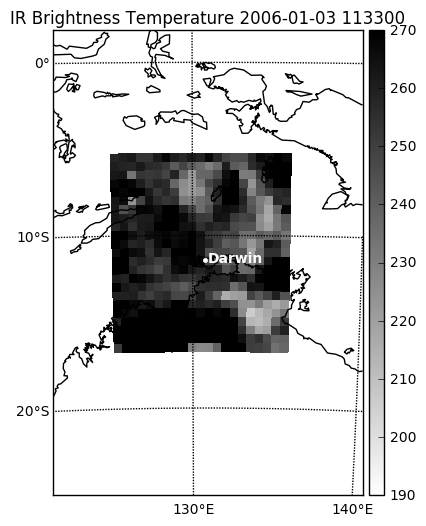

In [310]:
figure = plt.figure(figsize=(8,6))
for i in days:
    cdf_data = Dataset(file_list[i], mode='r')
    
    # Load lat, lon, and time parameters
    Latitude = cdf_data.variables['latitude']
    Longitude = cdf_data.variables['longitude']
    Time = cdf_data.variables['time']
    
    # Put lat and lon into 2D grid
    Lon, Lat = np.meshgrid(Longitude, Latitude)
    
    # Load brightness temperature
    IRBrightness = cdf_data.variables['ir_temperature']
    
    frames = np.arange(0,len(Time),1)
    Darwin_Lat = dms_to_decimal(-12,25,28.56)
    Darwin_Lon = dms_to_decimal(130,53,29.75)
    
    # Do loop for each frame in the time period
    start_secs_after_midnight = start_hour*3600 + start_minute*60 + start_second
    end_secs_after_midnight = end_hour*3600 + end_minute*60 + end_second
    for j in frames:
        if ((i == len(days)-1 and (Time[j] < end_secs_after_midnight)) 
            or (i == 0 and (Time[j] > start_secs_after_midnight))
            or (i > 0 and i < len(days)-1)):
        
            # Set up projection
            plt.clf()
            m = Basemap(width=2000000, height=3000000,
                       resolution='l', projection='stere', \
                       lat_0=Darwin_Lat,
                       lon_0=Darwin_Lon)

            xi, yi = m(Lon, Lat)
            darwin_x, darwin_y = m(Darwin_Lon, Darwin_Lat)

            # Plot data
            index = j
            data = np.squeeze(IRBrightness[index,:,:,0]) 

            colors = m.pcolor(xi, yi, data, cmap='gray_r', vmin=190, vmax=270)
            plt.text(darwin_x, darwin_y, 'Darwin', fontweight='bold', color='white')
            plt.plot(darwin_x*0.98, darwin_y*1.01, 'w.')

            m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
            m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)
            m.drawcoastlines()
            m.drawcountries()
            m.colorbar()
        
            year_str = "%04d" % year
            day_str = "%02d" % time_list[i].month
            month_str = "%02d" % time_list[i].day
            plt.title('IR Brightness Temperature ' 
                      + str(year) 
                      + '-' 
                      + str(day_str) 
                      + '-'
                      + str(month_str)
                      + ' ' 
                      + seconds_to_midnight_to_string(Time[index]))
        
            if not os.path.exists('./output_plots'):
                os.makedirs('./output_plots')
        
            plt.savefig('./output_plots/IRBrightnessTemp' 
                        + str(year) 
                        + str(day_str)  
                        + str(month_str)
                        + seconds_to_midnight_to_string(Time[index])
                        + '.png')

In [311]:
file_list

['/home/rjackson/data/visst/twpvisstgridm1rv1minnisX30.c1.20060101.003300.custom.cdf',
 '/home/rjackson/data/visst/twpvisstgridm1rv1minnisX30.c1.20060102.003300.custom.cdf',
 '/home/rjackson/data/visst/twpvisstgridm1rv1minnisX30.c1.20060103.003300.custom.cdf']